In [3]:
## ---- Partition Cell Set Network Module Cell Plotting ---- 0682.03.00
## Load Analysis Parameters (Parm1)
## Load Monocle Cell Sets
## Perform Special Gene (gene enrichment) Plots, Using Customized Code

In [4]:
## Create a Working Input and Output Data Directory, If Id Does Not Exist
parentdir <- '/gpfs/group/torkamani/devans/'
datdir <- paste(parentdir, 'CDC2', sep = '')
if (!file.exists(datdir)) {
    dir.create(datdir)
}
setwd(datdir)

In [5]:
## Read the parameters file
ps <- read.table(file = 'parms.txt', stringsAsFactors = FALSE, header = TRUE)

In [6]:
## Read the GENCODE v27 Data
v27_gen <- read.table(paste(ps$indir, 'v27_Embl_Hugo.txt', sep = ''), header = F)
v27_gen[,1] <- substr(v27_gen[,1] ,1, 15)
v27 <- read.table(paste(ps$indir, 'v27_Embl_Hugo_Type.txt', sep =''))

In [11]:
## Load Monocle3 and Seurat Libraries
library(monocle3)
library(Seurat)
library(dplyr)
library(magrittr)
library(ggplot2)
library(gridExtra)
library(Matrix)
library(rhdf5)
library(grid)
library(igraph)
library(corpcor)
library(fdrtool)
library(SDMTools)

In [8]:
## Read the previously preprocessed downsampled cell set data object
setwd(datdir)
down_stdycds <- readRDS(file = paste(ps$outdir,
            'Aggregated.downsampled.QC.NoDoublets.Repartitioned.rds', sep = ''))

## Build a gene short name to gene id (Ensembl) lookup
short2geneid <- fData(down_stdycds)@rownames
names(short2geneid) <- fData(down_stdycds)@listData$gene_short_name

## Build a gene id (Ensembl) to gene short name lookup
geneid2short <- fData(down_stdycds)@listData$gene_short_name
names(geneid2short) <- fData(down_stdycds)@rownames

In [9]:
## Create variables for how cells sets are organized
cellgrps <- c('healthy', 'diseased', 'healthy', 'diseased', 'healthy', 'diseased')
cellpats <- c('ID Number 1', 'ID Number 1', 'ID Number 2', 'ID Number 2', 'ID Number 3', 'ID Number 3')

## Define and Assign Cell Types
celltypes6 <- c('1-Macrophages',
                '2-Endothelial Cells',
                '3-VSMCs',
                '4-Natural Killer Cells',
                '5-Cytotoxic T Lymphocytes',
                '6-B Lymphocytes')

In [10]:
# Special Genes Set 2:

# ECs:
ec_mod1_genes <- c('ITLN1', 'S100A4', 'SCX')
ec_mod35_genes <- c('ESM1', 'PDGFD') 
ec_mod36_genes <- c('IER2', 'FOS')
## EC Gene IDs
ec_mod1_geneids <- short2geneid[ec_mod1_genes]
ec_mod35_geneids <- short2geneid[ec_mod36_genes]
ec_mod36_geneids <- short2geneid[ec_mod35_genes]

# VSMC:
vsmc_mod9_genes <- c('TNFAIP2', 'NFKBIA', 'SFRP5', 'CRTAC1')
vsmc_mod11_genes <- 'IGSF10'
vsmc_mod13_genes <- c('SPP1', 'IBSP', 'POSTN')
vsmc_mod30_genes <- c('TRA3', 'SEMA3C', 'C1QTNF3', 'NTM', 'FBN1')
vsmc_mod31_genes <- c('ZFP36', 'EGR1', 'JUNB', 'FOSB', 'FOS', 'IER2')
vsmc_mod31plus2_genes <- c(vsmc_mod31_genes, 'TNFAIP2', 'NFKBIA')
vsmc_mod9.31_genes <- c(vsmc_mod9_genes, vsmc_mod31_genes)
## VSMC Gene IDs
vsmc_mod13_geneids <- short2geneid[vsmc_mod9_genes]
vsmc_mod11_geneids <- short2geneid[vsmc_mod11_genes]
vsmc_mod13_geneids <- short2geneid[vsmc_mod13_genes]
vsmc_mod30_geneids <- short2geneid[vsmc_mod30_genes]
vsmc_mod31_geneids <- short2geneid[vsmc_mod31_genes]
vsmc_mod9.31_geneids <- short2geneid[vsmc_mod9.31_genes]
vsmc_mod31plus2_geneids <- short2geneid[vsmc_mod31plus2_genes]

In [12]:
Macrophages <- c('APOC1', 'FABP5', 'APOE', 'SDS', 'LYVE1', 'SCN9A', 'S100A12', 'P2RY14')
T_Cells     <- c('IGKC', 'MGP', 'IGLC2', 'PTGDS', 'FGFBP2', 'KLRF1')
B_Cells     <- c('MGP', 'TXNIP', 'HERPUD1', 'ZNF665', 'CRIP1', 'RAB11FIP1')
NKT_cells   <- c('IGKC', 'DUSP1', 'ZFP36', 'TSC22D3')

# Other VSMC and EC Genes for Enrichment plots

VSMC_AC_Cells <- c('SPP1', 'SFRP5', 'IBSP', 'CRTAC1')
VSMC_PA_Cells <- c('APOD', 'PLA2G2A', 'C3', 'MFAP5')
EC_AC_Cells <- c('ITLN1', 'DKK2', 'F5', 'FN1')
EC_PA_Cells <- c('IL6', 'MLPH', 'HLA-DQA1', 'ACKR1')

## Declare Tom's best genes for definiting cell types
toms_markers7 <- c('AIF1', 'CD14', 'CD68',
                   'VWF', 'PECAM1', 'ECSCR',
                   'CALD1', 'MYL9', 'TAGLN',
                   'NKG7', 'XCL1', 'CTSW',
                   'CD2', 'TRAC', 'CD69',
                   'CD79A', 'MS4A1', 'IGKC')

toms_gene_ids7 <- short2geneid[toms_markers7]

In [18]:
fig3c.vsmc <- VSMC_AC_Cells
fig3d.vsmc <- VSMC_PA_Cells
fig3g.ec <- EC_AC_Cells
fig3h.ec <- EC_PA_Cells
sfig3.all <- toms_markers7
sfig4c.macro <- Macrophages[c(1,2,3,5,6,7)] ## Removed genes SDS and P2RY14
sfig5c.tcells <- T_Cells
sfig6c.vsmc31 <- vsmc_mod31_genes
sfig6e.ec36 <- ec_mod36_genes

In [165]:
## Function for plotting gene enrichment in pdf format
gene_plot_pdf <- function(p, goi, pname, pnts, pflag = TRUE, scl = 1, ctxt = 1, pch = 20) { 
    pal2 <- colorRampPalette(c('black', 'orange', 'yellow'))

    path <- paste(datdir, '/', ps$outdir, 'geneplots4', sep = '')
    plotfile1 <- paste(path, '/CellPlot.GeneEnrichment.',
                       pname, '.', goi, '.bk.org.yel.rev4.pdf', sep = '') 

    cs <- 1
    alpha <- 1
    alphaz <- .15
    alphahex <- format(as.hexmode(as.integer(alpha * 255)), upper.case = TRUE)
    alphazhex <- format(as.hexmode(as.integer(alphaz * 255)), upper.case = TRUE)
    ncolors <- 100
    
    if (p != 'all') pcells <- down_stdycds[, colData(down_stdycds)$assigned_cell_type == celltypes6[p]]   
    else pcells <- down_stdycds
    
    umap <- pcells@reducedDims@listData$UMAP
    wgoi <- which(rownames(pcells) %in% short2geneid[goi])

    exp_pcells <- exprs(pcells)

    ## Special Cases for Outliers
    if ((goi == 'SPP1') &  (p == 3)) {
        outlier <- which(exp_pcells[wgoi, ] == 51)
        exp_pcells[wgoi, outlier] <- 5
        }
    
    log2gene <- as.integer(100 * log2(exp_pcells[wgoi, ] + 1 ))

    col_12 <- paste(pal2(max(log2gene) * 1 + 1), alphahex, sep = '')
    col_12l <- col_12
    col_12[1] <- paste(substr(col_12[1], 1, 7), alphazhex, sep = '')

    xrange <- max(umap[, 1]) - min(umap[, 1])
    yrange <- max(umap[, 2]) - min(umap[, 2])
    asp = xrange/yrange/0.8892482
    
    if (pflag) pdf(plotfile1, width = 8 * scl, height = 8 * scl / asp)
    plot(x = umap[, 1], y = umap[, 2],  pch = pch, 
        cex.main = cs * ctxt * scl, # cex.lab = cs * ctxt * scl,#  cex.axis = cs * ctxt * scl, 
        col = col_12[log2gene + 1], main = goi, xlab = 'UMAP 1', ylab = 'UMAP 2',
        )#mar = c(10, 8, 8, 4) + 0.1)
    
    legend.gradient(pnts, cols = col_12l, limits = c(0, max(log2gene)/ncolors),
                    title = "Log2 Expression")

    if (pflag) dev.off()
    return(NULL)
}

In [166]:
pnts = cbind(x = c(-4.2, -3.5, -3.5, -4.2), y = c(7, 7, 5, 5))
for (gene in fig3c.vsmc) {
    nval <- gene_plot_pdf(3, gene, 'VSMC.AC', pnts, pflag = TRUE, scl = 1, ctxt = 1.5, pch = 20)
    }    
for (gene in fig3d.vsmc) {
    nval <- gene_plot_pdf(3, gene, 'VSMC.PA', pnts, pflag = TRUE, scl = 1, ctxt = 1.5, pch = 20)
    }

pnts = cbind(x = c(2.5, 3, 3, 2.5), y = c(7, 7, 5.3, 5.3))
for (gene in fig3g.ec) {
    nval <- gene_plot_pdf(2, gene, 'EC.AC', pnts, pflag = TRUE, scl = 1, ctxt = 1.5, pch = 20)
    }    
for (gene in fig3h.ec) {
    nval <- gene_plot_pdf(2, gene, 'EC.PA', pnts, pflag = TRUE, scl = 1, ctxt = 1.5, pch = 20)
    }

pnts = cbind(x = c(8.5, 10, 10, 8.5), y = c(12, 12, 6, 6))
for (gene in toms_markers7) {
    nval <- gene_plot_pdf('all', gene, 'All', pnts, pflag = TRUE, scl = 1, ctxt = 3, pch = '.')
    }

In [175]:
pnts = cbind(x = c(10, 10.5, 10.5, 10), y = c(4, 4, 3, 3))
for (gene in sfig4c.macro) {
    nval <- gene_plot_pdf(1, gene, 'macro', pnts, pflag = TRUE, scl = 1, ctxt = 1.5, pch = 20)
    }    

In [181]:
pnts = cbind(x = c(-.75, -.3, -.3, -.75), y = c(-11, -11, -12.25, -12.25))
for (gene in sfig5c.tcells) {
    nval <- gene_plot_pdf(5, gene, 'tcells', pnts, pflag = TRUE, scl = 1, ctxt = 1.5, pch = 20)
    }    


In [183]:
pnts = cbind(x = c(-4.2, -3.5, -3.5, -4.2), y = c(7, 7, 5, 5))
for (gene in sfig6c.vsmc31) {
    nval <- gene_plot_pdf(3, gene, 'vsmc31', pnts, pflag = TRUE, scl = 1, ctxt = 1.5, pch = 20)
    } 

In [188]:
pnts = cbind(x = c(2.5, 3, 3, 2.5), y = c(7, 7, 5.3, 5.3))
for (gene in sfig6e.ec36) {
    nval <- gene_plot_pdf(2, gene, 'ec36', pnts, pflag = TRUE, scl = 1, ctxt = 1.5, pch = 20)
    } 

In [183]:
## Hacked up Monocle 3 Cell Plotting Code (Genes Plot)
## Code from this point on is abondoned/legacy
monocle_theme_opts <- function()
{
  theme(strip.background = element_rect(colour = 'white', fill = 'white')) +
    theme(panel.border = element_blank()) +
    theme(axis.line.x = element_line(size=0.25, color="black")) +
    theme(axis.line.y = element_line(size=0.25, color="black")) +
    theme(panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank()) +
    theme(panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_blank()) +
    theme(panel.background = element_rect(fill='white')) +
    theme(legend.key=element_blank())
}

plot_cells2 <- function(cds,
                       x=1,
                       y=2,
                       reduction_method = c("UMAP", "tSNE", "PCA", "LSI", "Aligned"),
                       color_cells_by="cluster",
                       group_cells_by=c("cluster", "partition"),
                       genes=NULL,
                       show_trajectory_graph=TRUE,
                       trajectory_graph_color="grey28",
                       trajectory_graph_segment_size=0.75,
                       norm_method = c("log", "size_only"),
                       label_cell_groups = TRUE,
                       label_groups_by_cluster=TRUE,
                       group_label_size=2,
                       labels_per_group=1,
                       label_branch_points=TRUE,
                       label_roots=TRUE,
                       label_leaves=TRUE,
                       graph_label_size=2,
                       cell_size=0.35,
                       cell_stroke= I(cell_size / 2),
                       alpha = 1,
                       min_expr=0.1,
                       rasterize=FALSE) {
  colx <- 'grey80'
  colx <- 'SkyBlue'
  optionv <- 'viridis'
  optionv <- 'B'
  
  reduction_method <- match.arg(reduction_method)
  assertthat::assert_that(methods::is(cds, "cell_data_set"))
  assertthat::assert_that(!is.null(reducedDims(cds)[[reduction_method]]),
                          msg = paste("No dimensionality reduction for",
                                      reduction_method, "calculated.",
                                      "Please run reduce_dimensions with",
                                      "reduction_method =", reduction_method,
                                      "before attempting to plot."))
  low_dim_coords <- reducedDims(cds)[[reduction_method]]
  assertthat::assert_that(ncol(low_dim_coords) >=max(x,y),
                          msg = paste("x and/or y is too large. x and y must",
                                      "be dimensions in reduced dimension",
                                      "space."))
  if(!is.null(color_cells_by)) {
    assertthat::assert_that(color_cells_by %in% c("cluster", "partition",
                                                  "pseudotime") |
                              color_cells_by %in% names(colData(cds)),
                            msg = paste("color_cells_by must one of",
                                        "'cluster', 'partition', 'pseudotime,",
                                        "or a column in the colData table."))

    if(color_cells_by == "pseudotime") {
      tryCatch({pseudotime(cds, reduction_method = reduction_method)},
               error = function(x) {
                 stop(paste("No pseudotime for", reduction_method,
                            "calculated. Please run order_cells with",
                            "reduction_method =", reduction_method,
                            "before attempting to color by pseudotime."))})

    }
  }
  assertthat::assert_that(!is.null(color_cells_by) || !is.null(markers),
                          msg = paste("Either color_cells_by or markers must",
                                      "be NULL, cannot color by both!"))

  norm_method = match.arg(norm_method)
  group_cells_by=match.arg(group_cells_by)
  assertthat::assert_that(!is.null(color_cells_by) || !is.null(genes),
                          msg = paste("Either color_cells_by or genes must be",
                                      "NULL, cannot color by both!"))

  if (show_trajectory_graph &&
      is.null(principal_graph(cds)[[reduction_method]])) {
    message("No trajectory to plot. Has learn_graph() been called yet?")
    show_trajectory_graph = FALSE
  }

  gene_short_name <- NA
  sample_name <- NA
  #sample_state <- colData(cds)$State
  data_dim_1 <- NA
  data_dim_2 <- NA
  if (rasterize){
    plotting_func <- ggrastr::geom_point_rast
  }else{
    plotting_func <- ggplot2::geom_point
  }

  S_matrix <- reducedDims(cds)[[reduction_method]]
  data_df <- data.frame(S_matrix[,c(x,y)])

  colnames(data_df) <- c("data_dim_1", "data_dim_2")
  data_df$sample_name <- row.names(data_df)

  data_df <- as.data.frame(cbind(data_df, colData(cds)))
  if (group_cells_by == "cluster"){
    data_df$cell_group <-
      tryCatch({clusters(cds,
                         reduction_method = reduction_method)[
                           data_df$sample_name]},
               error = function(e) {NULL})
  } else if (group_cells_by == "partition") {
    data_df$cell_group <-
      tryCatch({partitions(cds,
                           reduction_method = reduction_method)[
                             data_df$sample_name]},
               error = function(e) {NULL})
  } else{
    stop("Error: unrecognized way of grouping cells.")
  }

  if (color_cells_by == "cluster"){
    data_df$cell_color <-
      tryCatch({clusters(cds,
                         reduction_method = reduction_method)[
                           data_df$sample_name]},
               error = function(e) {NULL})
  } else if (color_cells_by == "partition") {
    data_df$cell_color <-
      tryCatch({partitions(cds,
                           reduction_method = reduction_method)[
                             data_df$sample_name]},
               error = function(e) {NULL})
  } else if (color_cells_by == "pseudotime") {
    data_df$cell_color <-
      tryCatch({pseudotime(cds,
                           reduction_method = reduction_method)[
                             data_df$sample_name]}, error = function(e) {NULL})
  } else{
    data_df$cell_color <- colData(cds)[data_df$sample_name,color_cells_by]
  }

  ## Graph info
  if (show_trajectory_graph) {

    ica_space_df <- t(cds@principal_graph_aux[[reduction_method]]$dp_mst) %>%
      as.data.frame() %>%
      dplyr::select_(prin_graph_dim_1 = x, prin_graph_dim_2 = y) %>%
      dplyr::mutate(sample_name = rownames(.),
                    sample_state = rownames(.))

    dp_mst <- cds@principal_graph[[reduction_method]]

    edge_df <- dp_mst %>%
      igraph::as_data_frame() %>%
      dplyr::select_(source = "from", target = "to") %>%
      dplyr::left_join(ica_space_df %>%
                         dplyr::select_(
                           source="sample_name",
                           source_prin_graph_dim_1="prin_graph_dim_1",
                           source_prin_graph_dim_2="prin_graph_dim_2"),
                       by = "source") %>%
      dplyr::left_join(ica_space_df %>%
                         dplyr::select_(
                           target="sample_name",
                           target_prin_graph_dim_1="prin_graph_dim_1",
                           target_prin_graph_dim_2="prin_graph_dim_2"),
                       by = "target")
  }

  ## Marker genes
  markers_exprs <- NULL
  expression_legend_label <- NULL
  if (!is.null(genes)) {
    if (!is.null(dim(genes)) && dim(genes) >= 2){
      markers = unlist(genes[,1], use.names=FALSE)
    } else {
      markers = genes
    }
    markers_rowData <- as.data.frame(subset(rowData(cds),
                                            gene_short_name %in% markers |
                                              row.names(rowData(cds)) %in%
                                              markers))
    if (nrow(markers_rowData) == 0) {
      stop("None of the provided genes were found in the cds")
    }
    if (nrow(markers_rowData) >= 1) {
      cds_exprs <- SingleCellExperiment::counts(cds)[row.names(markers_rowData), ,drop=FALSE]
      cds_exprs <- Matrix::t(Matrix::t(cds_exprs)/size_factors(cds))

      if (!is.null(dim(genes)) && dim(genes) >= 2){
        genes = as.data.frame(genes)
        row.names(genes) = genes[,1]
        genes = genes[row.names(cds_exprs),]

        agg_mat = as.matrix(my.aggregate.Matrix(cds_exprs, as.factor(genes[,2]),
                                                fun="sum"))

        agg_mat = t(scale(t(log10(agg_mat + 1))))
        agg_mat[agg_mat < -2] = -2
        agg_mat[agg_mat > 2] = 2
        markers_exprs = agg_mat
        markers_exprs <- reshape2::melt(markers_exprs)
        colnames(markers_exprs)[1:2] <- c('feature_id','cell_id')
        if (is.factor(genes[,2]))
          markers_exprs$feature_id = factor(markers_exprs$feature_id,
                                            levels=levels(genes[,2]))

        markers_exprs$feature_label <- markers_exprs$feature_id
        norm_method = "size_only"
        expression_legend_label = "Expression score"
      } else {
        cds_exprs@x = round(cds_exprs@x)
        markers_exprs = matrix(cds_exprs, nrow=nrow(markers_rowData))
        colnames(markers_exprs) = colnames(SingleCellExperiment::counts(cds))
        row.names(markers_exprs) = row.names(markers_rowData)
        markers_exprs <- reshape2::melt(markers_exprs)
        colnames(markers_exprs)[1:2] <- c('feature_id','cell_id')
        markers_exprs <- merge(markers_exprs, markers_rowData,
                               by.x = "feature_id", by.y="row.names")
        if (is.null(markers_exprs$gene_short_name)) {
          markers_exprs$feature_label <-
            as.character(markers_exprs$feature_id)
        } else {
          markers_exprs$feature_label <-
            as.character(markers_exprs$gene_short_name)
        }

        markers_exprs$feature_label <- ifelse(is.na(markers_exprs$feature_label) | !as.character(markers_exprs$feature_label) %in% markers,
                                              as.character(markers_exprs$feature_id),
                                              as.character(markers_exprs$feature_label))

        markers_exprs$feature_label <- factor(markers_exprs$feature_label,
                                              levels = markers)
        if (norm_method == "size_only")
          expression_legend_label = "Expression"
        else
          expression_legend_label = "log10(Expression)"
      }
    }
  }

  if (label_cell_groups && is.null(color_cells_by) == FALSE){
    if (is.null(data_df$cell_color)){
      if (is.null(genes)){
        message(paste(color_cells_by, "not found in colData(cds), cells will",
                      "not be colored"))
      }
      text_df = NULL
      label_cell_groups = FALSE
    }else{
      if(is.character(data_df$cell_color) || is.factor(data_df$cell_color)) {

        if (label_groups_by_cluster && is.null(data_df$cell_group) == FALSE){
          text_df = data_df %>%
            dplyr::group_by(cell_group) %>%
            dplyr::mutate(cells_in_cluster= dplyr::n()) %>%
            dplyr::group_by(cell_color, add=TRUE) %>%
            dplyr::mutate(per=dplyr::n()/cells_in_cluster)
          median_coord_df = text_df %>%
            dplyr::summarize(fraction_of_group = dplyr::n(),
                             text_x = stats::median(x = data_dim_1),
                             text_y = stats::median(x = data_dim_2))
          text_df = suppressMessages(text_df %>% dplyr::select(per) %>%
                                       dplyr::distinct())
          text_df = suppressMessages(dplyr::inner_join(text_df,
                                                       median_coord_df))
          text_df = text_df %>% dplyr::group_by(cell_group) %>%
            dplyr::top_n(labels_per_group, per)
        } else {
          text_df = data_df %>% dplyr::group_by(cell_color) %>%
            dplyr::mutate(per=1)
          median_coord_df = text_df %>%
            dplyr::summarize(fraction_of_group = dplyr::n(),
                             text_x = stats::median(x = data_dim_1),
                             text_y = stats::median(x = data_dim_2))
          text_df = suppressMessages(text_df %>% dplyr::select(per) %>%
                                       dplyr::distinct())
          text_df = suppressMessages(dplyr::inner_join(text_df,
                                                       median_coord_df))
          text_df = text_df %>% dplyr::group_by(cell_color) %>%
            dplyr::top_n(labels_per_group, per)
        }

        text_df$label = as.character(text_df %>% dplyr::pull(cell_color))
        # I feel like there's probably a good reason for the bit below, but I
        # hate it and I'm killing it for now.
        # text_df$label <- paste0(1:nrow(text_df))
        # text_df$process_label <- paste0(1:nrow(text_df), '_',
        # as.character(as.matrix(text_df[, 1])))
        # process_label <- text_df$process_label
        # names(process_label) <- as.character(as.matrix(text_df[, 1]))
        # data_df[, group_by] <-
        #  process_label[as.character(data_df[, group_by])]
        # text_df$label = process_label
      } else {
        message(paste("Cells aren't colored in a way that allows them to",
                      "be grouped."))
        text_df = NULL
        label_cell_groups = FALSE
      }
    }
  }

  if (!is.null(markers_exprs) && nrow(markers_exprs) > 0){
    data_df <- merge(data_df, markers_exprs, by.x="sample_name",
                     by.y="cell_id")
    data_df$value <- with(data_df, ifelse(value >= min_expr, value, NA))
    na_sub <- data_df[is.na(data_df$value),]
    if(norm_method == "size_only"){
      g <- ggplot(data=data_df, aes(x=data_dim_1, y=data_dim_2)) +
        plotting_func(aes(data_dim_1, data_dim_2), size=I(cell_size),
                      stroke = I(cell_stroke), color = colx, alpha = alpha,
                      data = na_sub) +
        plotting_func(aes(color=value), size=I(cell_size),
                      stroke = I(cell_stroke), na.rm = TRUE) +
        viridis::scale_color_viridis(option = optionv,
                                     name = expression_legend_label,
                                     na.value = colx, end = 0.8,
                                     alpha = alpha) +
        guides(alpha = FALSE) + facet_wrap(~feature_label)
    } else {
      g <- ggplot(data=data_df, aes(x=data_dim_1, y=data_dim_2)) +
        plotting_func(aes(data_dim_1, data_dim_2), size=I(cell_size),
                      stroke = I(cell_stroke), color = colx,
                      data = na_sub, alpha = alpha) +
        plotting_func(aes(color=log10(value+min_expr)),
                      size=I(cell_size), stroke = I(cell_stroke),
                      na.rm = TRUE, alpha = alpha) +
        viridis::scale_color_viridis(option = optionv,
                                     name = expression_legend_label,
                                     na.value = colx, end = 0.8,
                                     alpha = alpha) +
        guides(alpha = FALSE) + facet_wrap(~feature_label)
    }
  } else {
    g <- ggplot(data=data_df, aes(x=data_dim_1, y=data_dim_2))

    # We don't want to force users to call order_cells before even being able
    # to look at the trajectory, so check whether it's null and if so, just
    # don't color the cells
    if(color_cells_by %in% c("cluster", "partition")){
      if (is.null(data_df$cell_color)){
        g <- g + geom_point(color=I("gray"), size=I(cell_size),
                            stroke = I(cell_stroke), na.rm = TRUE,
                            alpha = I(alpha))
        message(paste("cluster_cells() has not been called yet, can't",
                      "color cells by cluster"))
      } else{
        g <- g + geom_point(aes(color = cell_color), size=I(cell_size),
                            stroke = I(cell_stroke), na.rm = TRUE,
                            alpha = alpha)
      }
      g <- g + guides(color = guide_legend(title = color_cells_by,
                                           override.aes = list(size = 4)))
    } else if (class(data_df$cell_color) == "numeric"){
      g <- g + geom_point(aes(color = cell_color), size=I(cell_size),
                          stroke = I(cell_stroke), na.rm = TRUE, alpha = alpha)
      g <- g + viridis::scale_color_viridis(name = color_cells_by, option="C")
    } else {
      g <- g + geom_point(aes(color = cell_color), size=I(cell_size),
                          stroke = I(cell_stroke), na.rm = TRUE, alpha = alpha)
      g <- g + guides(color = guide_legend(title = color_cells_by,
                                           override.aes = list(size = 4)))
    }

  }
  if (show_trajectory_graph){
    g <- g + geom_segment(aes_string(x="source_prin_graph_dim_1",
                                     y="source_prin_graph_dim_2",
                                     xend="target_prin_graph_dim_1",
                                     yend="target_prin_graph_dim_2"),
                          size=trajectory_graph_segment_size,
                          color=I(trajectory_graph_color),
                          linetype="solid",
                          na.rm=TRUE,
                          data=edge_df)


    if (label_branch_points){
      mst_branch_nodes <- branch_nodes(cds)
      branch_point_df <- ica_space_df %>%
        dplyr::slice(match(names(mst_branch_nodes), sample_name)) %>%
        dplyr::mutate(branch_point_idx = seq_len(dplyr::n()))

      g <- g +
        geom_point(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2"),
                   shape = 21, stroke=I(trajectory_graph_segment_size),
                   color="white",
                   fill="black",
                   size=I(graph_label_size * 1.5),
                   na.rm=TRUE, branch_point_df) +
        geom_text(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2",
                             label="branch_point_idx"),
                  size=I(graph_label_size), color="white", na.rm=TRUE,
                  branch_point_df)
    }

    if (label_leaves){
      mst_leaf_nodes <- leaf_nodes(cds)
      leaf_df <- ica_space_df %>%
        dplyr::slice(match(names(mst_leaf_nodes), sample_name)) %>%
        dplyr::mutate(leaf_idx = seq_len(dplyr::n()))

      g <- g +
        geom_point(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2"),
                   shape = 21, stroke=I(trajectory_graph_segment_size),
                   color="black",
                   fill="lightgray",
                   size=I(graph_label_size * 1.5),
                   na.rm=TRUE,
                   leaf_df) +
        geom_text(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2",
                             label="leaf_idx"),
                  size=I(graph_label_size), color="black", na.rm=TRUE, leaf_df)
    }

    if (label_roots){
      mst_root_nodes <- root_nodes(cds)
      root_df <- ica_space_df %>%
        dplyr::slice(match(names(mst_root_nodes), sample_name)) %>%
        dplyr::mutate(root_idx = seq_len(dplyr::n()))

      g <- g +
        geom_point(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2"),
                   shape = 21, stroke=I(trajectory_graph_segment_size),
                   color="black",
                   fill="white",
                   size=I(graph_label_size * 1.5),
                   na.rm=TRUE,
                   root_df) +
        geom_text(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2",
                             label="root_idx"),
                  size=I(graph_label_size), color="black", na.rm=TRUE, root_df)
    }
  }

  if(label_cell_groups) {
    g <- g + ggrepel::geom_text_repel(data = text_df,
                                      mapping = aes_string(x = "text_x",
                                                           y = "text_y",
                                                           label = "label"),
                                      size=I(group_label_size))
    # If we're coloring by gene expression, don't hide the legend
    if (is.null(markers_exprs))
      g <- g + theme(legend.position="none")
  }

  g <- g +
    #scale_color_brewer(palette="Set1") +
    monocle_theme_opts() +
    xlab(paste(reduction_method, x)) +
    ylab(paste(reduction_method, y)) +
    #guides(color = guide_legend(label.position = "top")) +
    theme(legend.key = element_blank()) +
    theme(panel.background = element_rect(fill='white'))
  g
}


No trajectory to plot. Has learn_graph() been called yet?


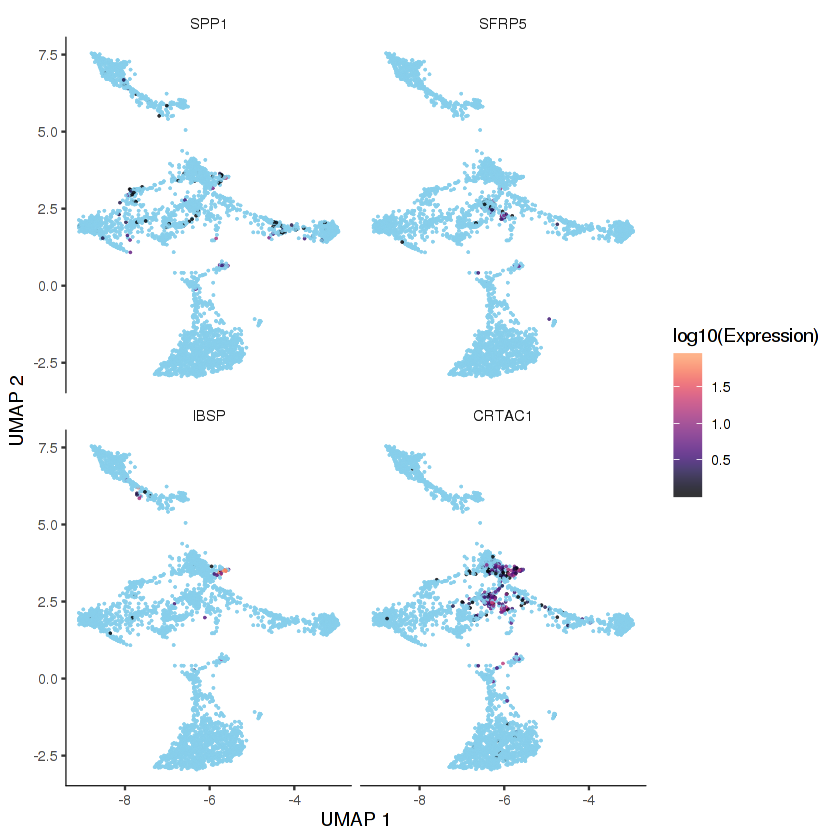

In [137]:
## Demo code for hacked up Moncole 3 Cell Plot Code
scale <- 1
cs <- .7 * scale * 1 * .6
alpha <- .8
p <- 3
path <- paste(datdir, '/', ps$outdir, celltypes6[p], sep = '')
plotfile1 <- paste(path, '/CellPlot.GeneEnrichment.VSMC.AC.SpecialGeneSet3.rev2.pdf', sep = '') 

# pdf(plotfile1, width = 6.5 * 1.5 * scale, height = 10 * scale)
    plot_cells2(down_stdycds[, colData(down_stdycds)$assigned_cell_type == celltypes6[p]],
           genes = VSMC_AC_Cells, label_cell_groups=FALSE, cell_size = cs, alpha = alpha)
# dev.off()

In [332]:
## This cel and the next cell were attempts to plot gene enrichment using colData variables
exp_stdycds <- exprs(down_stdycds)
wspp1 <- which(rownames(exp_stdycds) %in% short2geneid['SPP1'])
log2spp1 <- as.integer(log2(exp_stdycds[wspp1, ] + 1 ))
# log2spp1 <-  exp_stdycds[wspp1, ]
# log2spp1 <- max(log2spp1) - log2spp1
down_stdycds2 <- down_stdycds
down_stdycds2@colData$spp1 <- factor(log2spp1)
# down_stdycds2@colData$spp1[log2spp1 == 0] <- 0
# down_stdycds2@colData$spp1[log2spp1 > 1] <- 1
# down_stdycds2@colData$spp1[log2spp1 > 5] <- 2
# down_stdycds2@colData$spp1[log2spp1 > 7] <- as.character(3)
# down_stdycds2@colData$spp1 <- as.character(colData(down_stdycds2)$spp1)
table(colData(down_stdycds2)$spp1)


    0     1     2     3     4     5     6     7     8     9    10    11 
11611   655    91    76    84   119   141   155    91    35    10     2 

No trajectory to plot. Has learn_graph() been called yet?


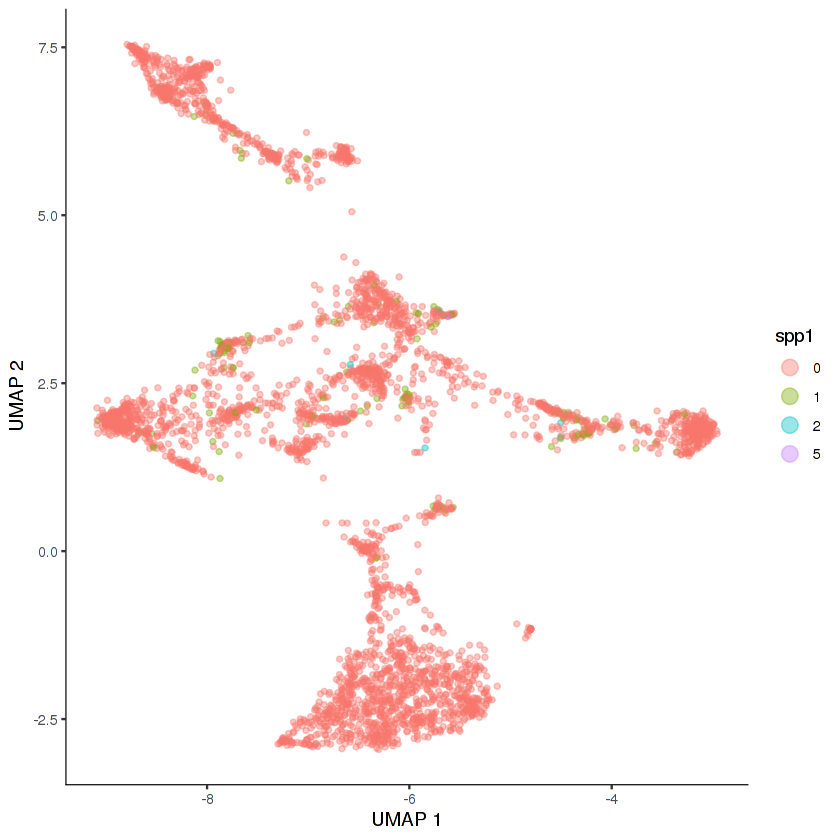

In [333]:
cols <- c("3" = "red", "2" = "blue", "1" = "orange")
scale <- 1
cs <- .7 * scale * 1 * 1.5
alpha <- .4
p <- 3
path <- paste(datdir, '/', ps$outdir, celltypes6[p], sep = '')
plotfile1 <- paste(path, '/CellPlot.GeneEnrichment.VSMC.AC.SpecialGeneSPP1.rev2.pdf', sep = '') 

# pdf(plotfile1, width = 6.5 * 1.5 * scale, height = 10 * scale)
plot_cells(down_stdycds2[, colData(down_stdycds)$assigned_cell_type == celltypes6[p]],
           label_cell_groups = FALSE, cell_size = cs, alpha = alpha,
           color_cells_by = "spp1")
# + 
#           scale_colour_manual(values = cols)
# dev.off()

In [42]:
goi <- 'SPP1'
pal2 <- colorRampPalette(c('black', 'orange', 'yellow'))
p <- 3

path <- paste(datdir, '/', ps$outdir, celltypes6[p], sep = '')
plotfile1 <- paste(path, '/CellPlot.GeneEnrichment.VSMC.AC.SpecialGeneSPP1.bk.org.yel.rev3.pdf', sep = '') 

cs <- .8
alpha <- 1
alphaz <- .15
alphahex <- format(as.hexmode(as.integer(alpha * 255)), upper.case = TRUE)
alphazhex <- format(as.hexmode(as.integer(alphaz * 255)), upper.case = TRUE)


vsmc <- down_stdycds[, colData(down_stdycds)$assigned_cell_type == celltypes6[p]]
umap <- vsmc@reducedDims@listData$UMAP
wspp1 <- which(rownames(vsmc) %in% short2geneid[goi])

exp_vsmc <- exprs(vsmc)
outlier <- which(exp_vsmc[wspp1, ] == 51)
exp_vsmc[wspp1, outlier] <- 5

log2spp1 <- as.integer(100 * log2(exp_vsmc[wspp1, ] + 1 ))

col_12 <- paste(pal2(max(log2spp1) * 1 + 1), alphahex, sep = '')
col_12l <- col_12
col_12[1] <- paste(substr(col_12[1], 1, 7), alphazhex, sep = '')

pdf(plotfile1, width = 10, height = 10)
plot(x = umap[, 1], y = umap[, 2],  pch = 20, cex = cs,
    col = col_12[log2spp1 + 1], main = goi, xlab = 'UMAP 1', ylab = 'UMAP 2')

pnts = cbind(x = c(-4.2, -3.5, -3.5, -4.2), y = c(7,7,5,5))
legend.gradient(pnts, cols = col_12l, limits = c(0, max(log2spp1)/100), title = "Log2 Expression  ")
dev.off()                                  

png 
  2

In [32]:
goi <- 'APOD'
pal2 <- colorRampPalette(c('black', 'orange', 'yellow'))
p <- 3

path <- paste(datdir, '/', ps$outdir, celltypes6[p], sep = '')
plotfile1 <- paste(path, '/CellPlot.GeneEnrichment.VSMC.AC.SpecialGeneAPOD.bk.org.yel.rev3.jpg', sep = '') 

ncolors <- 100
cs <- .8
alpha <- 1
alphaz <- .15
alphahex <- format(as.hexmode(as.integer(alpha * 255)), upper.case = TRUE)
alphazhex <- format(as.hexmode(as.integer(alphaz * 255)), upper.case = TRUE)

vsmc <- down_stdycds[, colData(down_stdycds)$assigned_cell_type == celltypes6[p]]
umap <- vsmc@reducedDims@listData$UMAP
wsgene <- which(rownames(vsmc) %in% short2geneid[goi])

exp_vsmc <- exprs(vsmc)
log2gene <- as.integer(ncolors * log2(exp_vsmc[wsgene, ] + 1 ))


col_12 <- paste(pal2(max(log2gene) * 1 + 1), alphahex, sep = '')
col_12l <- col_12
col_12[1] <- paste(substr(col_12[1], 1, 7), alphazhex, sep = '')

# pdf(plotfile1, width = 10, height = 10)
jpeg(plotfile1, width = 10, height = 10, quality = 95, units = 'in', res = 600)
plot(x = umap[, 1], y = umap[, 2],  pch = 20, cex = cs,
    col = col_12[log2gene + 1], main = goi, xlab = 'UMAP 1', ylab = 'UMAP 2')

pnts = cbind(x = c(-4.2, -3.5, -3.5, -4.2), y = c(7,7,5,5))
legend.gradient(pnts, cols = col_12l, limits = c(0, max(log2gene)/ncolors), title = "Log2 Expression  ")
dev.off()                                  

png 
  2

In [73]:
pnts = cbind(x = c(-4.2, -3.5, -3.5, -4.2), y = c(7, 7, 5, 5))
for (gene in fig3c.vsmc {
    nval <- gene_plot_jpg(3, gene, 'VSMC.AC', pnts)
    }
for (gene in fig3d.vsmc) {
    nval <- gene_plot_jpg(3, gene, 'VSMC.PA', pnts)
    }

pnts = cbind(x = c(2.5, 3, 3, 2.5), y = c(7, 7, 5.3, 5.3))
for (gene in fig3g.ec) {
    nval <- gene_plot_jpg(2, gene, 'EC.AC', pnts)
    }    
for (gene in fig3h.ec) {
    nval <- gene_plot_jpg(2, gene, 'EC.PA', pnts)
    }

In [72]:
## Function for plotting gene enrichment in jpeg format
gene_plot_jpg <- function(p, goi, pname, pnts, pflag = TRUE) { 
    pal2 <- colorRampPalette(c('black', 'orange', 'yellow'))

    path <- paste(datdir, '/', ps$outdir, 'geneplots1', sep = '')
    plotfile1 <- paste(path, '/CellPlot.GeneEnrichment.',
                       pname, '.', goi, '.bk.org.yel.rev3.jpg', sep = '') 

    cs <- .8
    alpha <- 1
    alphaz <- .15
    alphahex <- format(as.hexmode(as.integer(alpha * 255)), upper.case = TRUE)
    alphazhex <- format(as.hexmode(as.integer(alphaz * 255)), upper.case = TRUE)
    ncolors <- 100
    
    pcells <- down_stdycds[, colData(down_stdycds)$assigned_cell_type == celltypes6[p]]    
    umap <- pcells@reducedDims@listData$UMAP
    wgoi <- which(rownames(pcells) %in% short2geneid[goi])

    exp_pcells <- exprs(pcells)

    ## Special Cases for Outliers
    if ((goi == 'SPP1') &  (p == 3)) {
        outlier <- which(exp_pcells[wgoi, ] == 51)
        exp_pcells[wgoi, outlier] <- 5
        }
    
    log2gene <- as.integer(100 * log2(exp_pcells[wgoi, ] + 1 ))

    col_12 <- paste(pal2(max(log2gene) * 1 + 1), alphahex, sep = '')
    col_12l <- col_12
    col_12[1] <- paste(substr(col_12[1], 1, 7), alphazhex, sep = '')

    if (pflag) jpeg(plotfile1, width = 10, height = 10, quality = 95, units = 'in', res = 600)
    plot(x = umap[, 1], y = umap[, 2],  pch = 20, cex = cs,
        col = col_12[log2gene + 1], main = goi, xlab = 'UMAP 1', ylab = 'UMAP 2')

    # pnts = cbind(x = c(-4.2, -3.5, -3.5, -4.2), y = c(7,7,5,5))
    legend.gradient(pnts, cols = col_12l, limits = c(0, max(log2gene)/ncolors), title = "Log2 Expression  ")
    if (pflag) dev.off()
    return(NULL)
}